In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly
# import PIL
import tensorflow as tf
# import tensorflow_probability as tfp
# import tensorflow.contrib as tf_contrib
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error

from sklearn.pipeline import make_pipeline
import joblib

import calendar

import pandas as pd

import seaborn as sns
from data_utils import *

2022-10-28 14:40:35.773233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Presaved Data

In [2]:
# Set the directory for your local machine

# data_dir = r'D:\Projects\MobilityForecast\Repo\mobilityforecast\data'
data_dir = '/Users/probook/Documents/GitHub/mobility-mini-project/data/'
data_all = pd.read_csv(data_dir + 'feedforward_2021.csv', delimiter=',')
data_all.pop('Unnamed: 0')
data = data_all.copy()

In [3]:
data.head()

,pickup_month_sin,pickup_month_cos,pickup_day_sin,pickup_day_cos,pickup_hour_sin,pickup_hour_cos,start_end,temperature (degC),wind_speed (m/s),total_precipitation (mm of water equivalent),snowfall (mm of water equivalent),snow_depth (mm of water equivalent),taxi_demand,bike_demand
0,0.5,0.866025,0.0,1.0,0.0,1.0,0.1008,0.0,0.0,0.0,0.0,0.0,0.000066,0.0
1,0.5,0.866025,0.0,1.0,0.0,1.0,0.1104,0.0,0.0,0.0,0.0,0.0,0.000033,0.0
2,0.5,0.866025,0.0,1.0,0.0,1.0,0.1376,0.0,0.0,0.0,0.0,0.0,0.000098,0.0
3,0.5,0.866025,0.0,1.0,0.0,1.0,0.1488,0.0,0.0,0.0,0.0,0.0,0.000033,0.0
4,0.5,0.866025,0.0,1.0,0.0,1.0,0.1616,0.0,0.0,0.0,0.0,0.0,0.000033,0.0


In [4]:
y1 = data.pop('taxi_demand').values
y2 = data.pop('bike_demand').values

In [5]:
data_array = data.to_numpy()

In [6]:
# train_ind = int(np.round(0.85*len(data_array)))
# x_train = data_array[:train_ind]
# x_test = data_array[train_ind:]
# y1_train = y1[:train_ind]
# y1_test = y1[train_ind:]
# y2_train = y2[:train_ind]
# y2_test = y2[train_ind:]

# Split data into train and test
x_train, x_test, y1_train, y1_test, y2_train, y2_test = train_test_split(data_array, y1, y2, test_size=0.2, random_state=42)


In [7]:
x_train = pd.DataFrame(x_train, columns=data.columns)
x_test = pd.DataFrame(x_test, columns=data.columns)

In [8]:
x_train = tf.cast(x_train.values, tf.float32)
x_test = tf.cast(x_test.values, tf.float32)

y1_train = tf.cast(y1_train, tf.float32)
y1_test = tf.cast(y1_test, tf.float32)

y2_train = tf.cast(y2_train, tf.float32)
y2_test = tf.cast(y2_test, tf.float32)

Metal device set to: AMD Radeon Pro 5300M

systemMemory: 16.00 GB
maxCacheSize: 1.99 GB



2022-10-28 14:40:45.919688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-28 14:40:45.924827: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-28 14:40:45.925034: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-28 14:40:45.925901: I tensorflow/core/common_runtime/pluggable_device/plug

In [9]:
# Reshape y1 and y2 to be 2D
y1_train = tf.reshape(y1_train, (-1, 1))
y1_test = tf.reshape(y1_test, (-1, 1))
y2_train = tf.reshape(y2_train, (-1, 1))
y2_test = tf.reshape(y2_test, (-1, 1))

In [10]:
print('input training and test shapes',x_train.shape, x_test.shape)
print('1 output training and test shapes',y1_train.shape, y1_test.shape)
print('1 output training and test shapes',y2_train.shape, y2_test.shape)

input training and test shapes (325497, 12) (81375, 12)
1 output training and test shapes (325497, 1) (81375, 1)
1 output training and test shapes (325497, 1) (81375, 1)


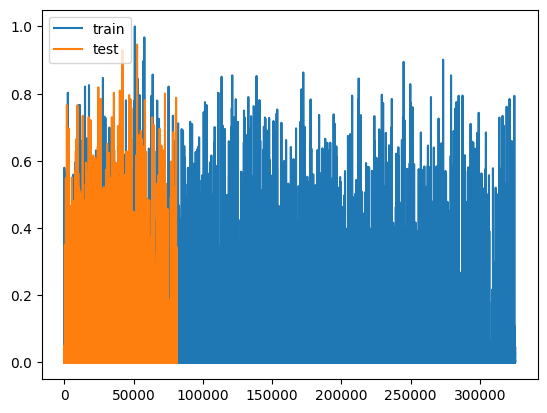

In [11]:
plt.plot(y1_train)
plt.plot(y1_test)
# legend
plt.legend(['train', 'test'], loc='upper left')

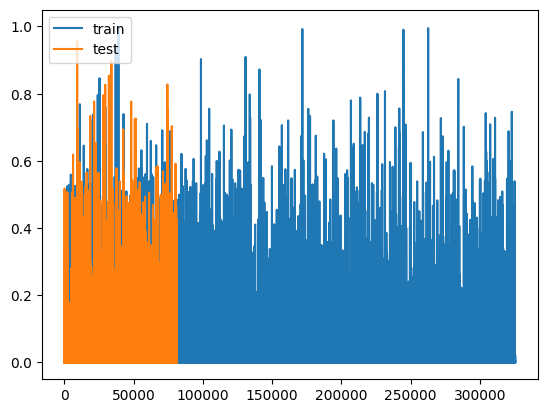

In [12]:
plt.plot(y2_train)
plt.plot(y2_test)
# legend
plt.legend(['train', 'test'], loc='upper left')

# Scikit-Learn Models

In [37]:
y_train = tf.concat([y1_train, y2_train], axis=1)
y_test = tf.concat([y1_test, y2_test], axis=1)
clf = MultiOutputRegressor(RandomForestRegressor(max_depth=2, random_state=0))
clf.fit(x_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=2,
                                                     random_state=0))

In [38]:
demand = clf.predict(tf.reshape(x_test[3], (1, 12)))
demand

array([[9.39115494e-04, 1.74962699e-07]])

In [39]:
print("MAE :", mean_absolute_error(y_test,clf.predict(x_test)))

MAE : 0.004175793293487866


In [41]:
# Load the taxi and bike demand scalers
taxi_scaler = joblib.load('taxi_scaler.gz')
bike_scaler = joblib.load('bike_scaler.gz')

In [42]:
demand_scaled = [taxi_scaler.inverse_transform(demand[0][0].reshape(-1,1)), bike_scaler.inverse_transform(demand[0][1].reshape(-1,1))]
demand_scaled

[array([[28.61578821]]), array([[0.00405039]])]

In [44]:
# save the model to disk
filename = 'mo_regressor.sav'
joblib.dump(clf, filename)

['mo_regressor.sav']

In [45]:
# load the model from disk
loaded_model = joblib.load(filename)

In [ ]:
def normalize_inputs(inputs):
    rho_scaler = joblib.load('rho_scaler.gz')
    theta_scaler = joblib.load('theta_scaler.gz')
    temperature_scaler = joblib.load('temp_scaler.gz')
    
    inputs['rho'] = rho_scaler.transform(inputs['rho'].values.reshape(-1,1))
    inputs['theta'] = theta_scaler.transform(inputs['theta'].values.reshape(-1,1))
    inputs['temperature (degC)'] = temperature_scaler.transform(inputs['temperature (degC)'].values.reshape(-1,1))
    return inputs

In [ ]:
def query_model(features, model):
    """
    Query the model for a prediction given a set of features.

    Parameters
    ----------
    features : dict
        A dictionary of features to query the model with.
        Features should be in the following format:
        {start_lat: float, start_lon: float, pickup_day: int[0:7], pickup_hour: int[0:24], 
        temperature: float, precip: int[0,1], wind: int[0,1], snowfall: int[0,1], snowcover: int[0,1]}

    Returns
    -------
    prediction : int
        The predicted taxi demand for the given features.

    """

    # Transform latitude and longitude to radians and scale
    rho, theta = cart2pol(features['start_lon'], features['start_lat']) 

    norm_features = {'rho': rho, 'theta': theta, 'temperature (degC)': features['temperature (degC)']}

    # Transform the inputs to match the training 
    norm_inputs = normalize_inputs(pd.DataFrame(norm_features, index=[0]))

    pickup_month_sin = np.sin(2 * np.pi * features['pickup_month']/12)
    pickup_month_cos = np.cos(2 * np.pi * features['pickup_month']/12)
    pickup_day_sin = np.sin(2 * np.pi * features['pickup_day']/7)
    pickup_day_cos = np.cos(2 * np.pi * features['pickup_day']/7)
    pickup_hour_sin = np.sin(2 * np.pi * features['pickup_hour']/24)
    pickup_hour_cos = np.cos(2 * np.pi * features['pickup_hour']/24)

    rho = norm_inputs['rho'][0]
    theta = norm_inputs['theta'][0]
    temp = norm_inputs['temperature (degC)'][0]

    # Month, day, hour, location, weather
    query_features = np.array([pickup_month_sin, pickup_month_cos, pickup_day_sin, pickup_day_cos, pickup_hour_sin, pickup_hour_cos, rho, theta, temp, features['wind'], features['precip'],  features['snowfall'], features['snowcover']])

    # print('Query Inputs: ', query_features)

    taxi_demand_scaler = joblib.load('taxi_demand_scaler.gz')
    bike_demand_scaler = joblib.load('bike_demand_scaler.gz')
    
    # # # Get the prediction
    X = tf.convert_to_tensor(query_features)
    X = tf.cast(X, tf.float32)
    prediction = model.predict(tf.reshape(X, (1,13)))
    demand_scaled = [taxi_demand_scaler.inverse_transform(prediction[0][0].reshape(-1,1)), bike_demand_scaler.inverse_transform(prediction[0][1].reshape(-1,1))]

    return np.array((demand_scaled[0][0][0], demand_scaled[1][0][0]))

In [ ]:
model = joblib.load('mo_regressor.sav')

features = {'start_lat': 40.64, 'start_lon': -74.08, 'year': 2021, 'pickup_month': 1, 'pickup_day': 1, 'pickup_hour': 0, 
'temperature (degC)': 4.33, 'precip': 0, 'wind': 0, 'snowfall': 0, 'snowcover': 0}

result = query_model(features, model)
print(result)

# Simple Custom Models

In [13]:
# https://stackoverflow.com/questions/44036971/multiple-outputs-in-keras
inputs = tf.keras.layers.Input(shape=(x_train.shape[1],), name='input')
x = tf.keras.layers.Dense(1024, 'tanh', kernel_initializer='glorot_uniform', name='1024_1')(inputs)
x = tf.keras.layers.Dense(512,  kernel_initializer='glorot_uniform', name='512_1')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, 'tanh', kernel_initializer='glorot_uniform', name='256_1')(x)
x = tf.keras.layers.Dense(128, 'tanh', kernel_initializer='glorot_uniform', name='128_1')(x)
x = tf.keras.layers.Dense(256, 'tanh', kernel_initializer='glorot_uniform', name='256_2')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, 'tanh', kernel_initializer='glorot_uniform', name='128_2')(x)
x = tf.keras.layers.Dense(128, 'tanh', kernel_initializer='glorot_uniform', name='128_3')(x)
x = tf.keras.layers.Dense(64, 'tanh', kernel_initializer='glorot_uniform', name='64')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(32, 'tanh', kernel_initializer='glorot_uniform', name='32')(x)
x = tf.keras.layers.Dense(16,'tanh',  kernel_initializer='glorot_uniform', name='16')(x)
x = tf.keras.layers.BatchNormalization()(x)
output1 = tf.keras.layers.Dense(1, 'sigmoid', name='taxi_demand')(x)
output2 = tf.keras.layers.Dense(1, 'sigmoid', name='bike_demand')(x)

model = tf.keras.Model(inputs=inputs, outputs=[output1, output2])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 12)]         0           []                               
                                                                                                  
 1024_1 (Dense)                 (None, 1024)         13312       ['input[0][0]']                  
                                                                                                  
 512_1 (Dense)                  (None, 512)          524800      ['1024_1[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512)         2048        ['512_1[0][0]']                  
 alization)                                                                                   

In [15]:
loss_taxi_reg = tf.keras.losses.MeanAbsoluteError()#tf.keras.losses.MeanSquaredLogarithmicError()
loss_bike_reg = tf.keras.losses.MeanAbsoluteError() #tf.keras.losses.MeanSquaredLogarithmicError()

pred_error_taxi = tf.keras.metrics.MeanAbsoluteError(name='taxi')
pred_error_bike = tf.keras.metrics.MeanAbsoluteError(name='bike')

opt = tf.keras.optimizers.Adam(learning_rate = 0.1)

In [16]:
model.compile(loss={'taxi_demand': loss_taxi_reg, 'bike_demand': loss_bike_reg}, optimizer=opt, metrics= ['mae']) #,

In [17]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [18]:
EPOCHS = 1

history = model.fit(x_train, {'taxi_demand': y1_train, 'bike_demand': y2_train}, verbose=2,callbacks=reduce_lr,validation_split=0.2, epochs=EPOCHS, batch_size=8)

2022-10-28 14:41:04.181991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-28 15:07:38.719838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32550/32550 - 1736s - loss: 0.0060 - taxi_demand_loss: 0.0028 - bike_demand_loss: 0.0032 - taxi_demand_mae: 0.0028 - bike_demand_mae: 0.0032 - val_loss: 0.0059 - val_taxi_demand_loss: 0.0028 - val_bike_demand_loss: 0.0031 - val_taxi_demand_mae: 0.0028 - val_bike_demand_mae: 0.0031 - lr: 0.1000 - 1736s/epoch - 53ms/step


In [ ]:
history.history.keys()

In [ ]:
_,_,_,test_taxi_mae, test_bike_mae = model.evaluate(x_test,{'taxi_demand': y1_test, 'bike_demand': y2_test})

In [ ]:
from turtle import color


plt.plot(history.history['taxi_demand_mae'], '-', label='taxi_train_mae')
plt.plot(history.history['val_taxi_demand_mae'], 'r-.',label='taxi_val_mae')
plt.axhline(y=test_taxi_mae, color='k', label='taxi_test_mae')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error(mae)')
plt.title('Normalized Taxi Demand Performance')

In [ ]:
plt.fill_between(np.arange(0,500),history.history['taxi_demand_mae'], history.history['val_taxi_demand_mae'])
plt.legend(['train_taxi_mae','val_taxi_mmae'],loc='best')

In [ ]:
plt.plot(history.history['bike_demand_mae'], '-', label='taxi_train_mae')
plt.plot(history.history['val_bike_demand_mae'], 'r-.',label='taxi_val_mae')
plt.axhline(y=test_bike_mae, color='k', label='taxi_test_mae')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error(mae)')
plt.title('Normalized Bike Demand Performance')